# Hands on Embeddings - implementing word2vec using Gensim 

Word2vec is a popular technique to learn word embeddings. It uses a two-layer neural network. Its input is a text corpus and its output is a set of vectors. Word embedding via word2vec can make natural language computer-readable, then further implementation of mathematical operations on words can be used to detect their similarities. A well-trained set of word vectors will place similar words close to each other in that space. For instance, the words women, men and human might cluster in one corner, while yellow, red and blue cluster together in another.

Word2Vec was introduced in two papers between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by Gensim.

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

There are two main training algorithms for word2vec, one is the continuous bag of words(CBOW), another is called skip-gram. The major difference between these two methods is that CBOW is using context to predict a target word while skip-gram is using a word to predict a target context. Generally, the skip-gram method can have a better performance compared with CBOW method, for it can capture two semantics for a single word. For instance, it will have two vector representations for Apple, one for the company and another for the fruit.

### word2vec using Gensim 

In this example we use the Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html
        
Gensim is an open-source library for unsupervised topic modeling and natural language processing, using modern statistical machine learning. Gensim is implemented in Python and Cython.

In this example we take a text document and clean it and then train a word2vec model. We will perform some cleaning and preprocessing of the text to produce a simple list of lists of tokens. For larger corpora it is better to use an iterable that streams the sentences directly from disk/network.

We will then take the model and use it to look a similarity and try to visulise the vectors. 


### The text
The data set we will use here is the text from Alice in Wonderland. This is freely available from http://www.gutenberg.org/. Gutenberg is a library of over 60,000 free eBooks and a great source of text if you want to start exploring NLP and text mining.

### The packages

We will use use a variety of packages to demonstrate different aspects of cleaning and processing the text data:

* re for stripping away some characters using regex
* Gensim for simple processing, phrase detection and word2vec
* NLTK for a source of stopwords

In addition we will use
* matplotlib for plotting and visualising the embeddings
* sklearn for tSNE


In [2]:
import re
import spacy
from gensim.models.phrases import Phrases, Phraser
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
% matplotlib inline

from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
import numpy as np

## Lets load some data

In [3]:
with open("pg28885.txt", encoding='latin-1') as f:
    alice_raw_text = f.readlines()
    
# View the first 250 rows to access quality  
alice_raw_text[:250]    

['bplist00Ñ\x01\x02_\x10\x0fWebMainResourceÕ\x03\x04\x05\x06\x07\x08\t\n',
 '\x0b\x0c_\x10\x14WebResourceFrameName_\x10\x0fWebResourceData_\x10\x13WebResourceMIMEType_\x10\x1bWebResourceTextEncodingName^WebResourceURLPO\x12\x00\x02¥³<html><head></head><body><pre style="word-wrap: break-word; white-space: pre-wrap;">Project Gutenberg\'s Alice\'s Adventures in Wonderland, by Lewis Carroll\n',
 '\n',
 'This eBook is for the use of anyone anywhere at no cost and with\n',
 'almost no restrictions whatsoever.  You may copy it, give it away or\n',
 're-use it under the terms of the Project Gutenberg License included\n',
 'with this eBook or online at www.gutenberg.net\n',
 '\n',
 '\n',
 "Title: Alice's Adventures in Wonderland\n",
 '       Illustrated by Arthur Rackham. With a Proem by Austin Dobson\n',
 '\n',
 'Author: Lewis Carroll\n',
 '\n',
 'Illustrator: Arthur Rackham\n',
 '\n',
 'Release Date: May 19, 2009 [EBook #28885]\n',
 '\n',
 'Language: English\n',
 '\n',
 '\n',
 "*** START OF T

The data is one long file, with preamble, table of contents and post licence information. It is useful to split the text into chapters and remove anything other than the book text.

In [4]:
# Split into chapters - each chapter has is indicated by the text CHAPTER
chapters = ''.join(alice_raw_text).split('CHAPTER')

# We dont want the first preamble and table of contents
chapters.pop(0)

# Split the last chapter by 'The End' so we can remove all end liscencing info
n = len(chapters)-1
end = chapters[n].split("THE END")

chapters[n] = end[0]

# Lets view the forst 20 characters for each chapter
for m in chapters:
    print(m[:20])


 I


[Sidenote: _Dow
 II


[Sidenote: _Po
 III


[Sidenote: _A
 IV


[Sidenote: _Th
 V


[Sidenote: _Adv
 VI


[Sidenote: _Pi
 VII


[Sidenote: _A
 VIII


[Sidenote: _
 IX


[Sidenote: _Th
 X


[Sidenote: _The
 XI


[Sidenote: _Wh
 XII


[Sidenote: _A


## Preprocessing
We need to do some pre-processing for the text. Lets keep it simple for thid example:

1. Initial cleaning of strings
2. Remove all punctuation and convert to lowercase
3. Lemmatise


Pre-processing is dependednt on your data and should be refined on each application. fpor example you may want to remove any emails using:

data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

or use some of the very useful tagging in spaCy, e.g.,  isUrl or isEmail properties https://spacy.io/api/token

In [5]:
# Convert to list
data = chapters

# Remove first line in each chapter (the chapter number)
data = [re.sub(r"^.*\n", "", sent) for sent in data]

# Remove chapters titles/illustraions/sidenotes - these are of the form "[text]"
data = [re.sub("[\[].*?[\]]", " ", sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove the ***** text lines in the text
data = [re.sub("\*", "", sent) for sent in data]

# Remove the _ characters in the text
data = [re.sub("_", " ", sent) for sent in data]

# Lets look at how the text now looks
for m in data:
    print("CHAPTER text: %s" % m[:50])

CHAPTER text:  ALICE was beginning to get very tired of sitting 
CHAPTER text:  "CURIOUSER and curiouser!" cried Alice (she was s
CHAPTER text:  THEY were indeed a queer-looking party that assem
CHAPTER text:  IT was the White Rabbit, trotting slowly back aga
CHAPTER text:  THE Caterpillar and Alice looked at each other fo
CHAPTER text:  FOR a minute or two she stood looking at the hous
CHAPTER text:  THERE was a table set out under a tree in front o
CHAPTER text:  A LARGE rose-tree stood near the entrance of the 
CHAPTER text:  "YOU can't think how glad I am to see you again, 
CHAPTER text:  THE Mock Turtle sighed deeply, and drew the back 
CHAPTER text:  THE King and Queen of Hearts were seated on their
CHAPTER text:  "HERE!" cried Alice, quite forgetting in the flur


### Lets perform some simple preprocessing - we can use the build in pipeline in Gensim for this, although you can build your own.

Now we have included stopword removal, bigram and trigram - but are these necessary?! 

#### Think of the pros and cons.

Do stopwords add noise? Does removing them remove context?
Does identifying common phrases help enrich the model? is your corpus big enough to identify them?

It all depends on what kind of experiment you are running and how you want to represent your documents. You can vector-ize your documents in different ways, depending on ther size of your corpus and context.


To prepare your document for preprocessing and Gensim Word2Vec, we need to tokenise it to produse a list of lists of words.

In this case each chapter becomes a list of tokenised words. 


In [6]:
def doc_to_words(sentences):
    for sentence in sentences:
        yield(simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(doc_to_words(data))

# Lets view the first 20 words in the first chapter
print(data_words[0][:20])

['alice', 'was', 'beginning', 'to', 'get', 'very', 'tired', 'of', 'sitting', 'by', 'her', 'sister', 'on', 'the', 'bank', 'and', 'of', 'having', 'nothing', 'to']


## Bigrams and trigrams
There are a number of ways to identify phrases through a corpus. Here we show how to use the Phraser utility in Gensim. This lets you automatically detect phrases longer than one word. Using phrases, you can learn a word2vec model where “words” are actually multiword expressions, such as new_york_times or financial_crisis:

Firstly create a Phrases object, initialised with the text and some settings to control the sensitivity .
Then feed this to a Phraser object, which can be used to create bigrams. 

To get trigrams, just repeat the Phraser operation on the bigrams.
https://web.stanford.edu/class/archive/cs/cs224n/cs224n.1174/reports/2761021.pdf

In [7]:
bigram_phrases = Phrases(data_words, min_count=2, threshold=1)
bigram = Phraser(bigram_phrases)

trigram_phrases = Phrases(bigram[data_words], min_count=1, threshold=1, delimiter=b' ')
trigram = Phraser(trigram_phrases)

Lets create some fucntions to help with our pipleine. We utilise spaCy for Lemmatisation and removal of some words, but you could also use NLTK.

In [26]:
# Define functions for stopwords, bigrams, trigrams and lemmatization


# Gensim simple processing pipleine - lowercase and tokensises 
def simple_preprocessing(texts):
    return [[word for word in simple_preprocess(str(doc))] for doc in texts]

def make_bigrams(texts):
    return [bigram[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram[doc] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """
    use spaCy lemmatisation - allowing through Nouns, Adjectives, Verbs and adverbs only
    
    https://spacy.io/api/annotation
    """
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags and token.lemma_ != '-PRON-'])
    return texts_out

### Preprocessing pipeline

We are now in position to create a pipeline to prepare the text, adding or ommitting steps as required.
Here we will remove stopwords, lemmatize create bigrams and trigrams.

-> Do you think the order of the processing matters?

-> Why would you add custom stopwords?

-> What is the effect of some preprocessing on the CBOW/skip gram models? 

-> Should you remove punctuation??

Remember that word2vec is not just a vector representing a word, but a vector representing a word and its surrounding words. 

In [27]:
# Simple Genism processing 

data_words_preprocessed = simple_preprocessing(data_words)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_words_lemmatized = lemmatization(data_words_preprocessed, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_lemmatized)

# Form Trigrams
data_words_trigrams = make_trigrams(data_words_bigrams)

data_processed = data_words_trigrams

print(data_processed[0][:200])

['alice', 'be', 'begin', 'get', 'very_tired', 'sit', 'sister', 'bank', 'have', 'nothing', 'do', 'once', 'twice', 'have', 'peep', 'book', 'sister', 'be', 'read', 'have', 'picture', 'conversation', 'what', 'be', 'use', 'book', 'think', 'alice', 'picture', 'conversation', 'be', 'consider', 'own', 'mind', 'as_well', 'could', 'hot', 'day', 'make', 'feel_very', 'sleepy', 'stupid', 'pleasure', 'make', 'daisy', 'chain', 'would_be', 'worth', 'trouble', 'get', 'pick', 'daisy', 'when_suddenly', 'white_rabbit', 'pink', 'eye', 'run', 'close', 'there', 'be', 'nothing', 'so_very', 'remarkable', 'do', 'alice', 'think', 'so_very', 'much', 'way', 'hear', 'rabbit', 'say', 'dear_shall', 'be', 'too late', 'when', 'think', 'afterwards', 'occur', 'ought', 'have', 'wonder', 'time', 'seem', 'quite', 'natural', 'when', 'rabbit', 'actually', 'take', 'watch', 'waistcoat', 'pocket', 'look', 'then', 'hurry', 'alice', 'start', 'foot', 'flash', 'mind', 'have', 'never', 'before', 'see', 'rabbit', 'waistcoat', 'pocket'

### Gensim Word2vec

We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

We are using a simple list of lists of tokens, but for larger corpora it is better to use an iterable that streams the sentences directly from disk/network.

In [46]:
# Initialise the model - CBOW 
w2v_model = Word2Vec(min_count=1,
                     window=5,
                     size=200)

# add sg=1 for skipgram model
# Adjust min count and window nased on size and type of text
# Window is the number of words either side of the word that are included when training the embedding.

In [47]:
# Build the vocab
w2v_model.build_vocab(data_processed, progress_per=10000)

In [48]:
# Train the model
w2v_model.train(data_processed, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

(342680, 419310)

In [49]:
# Normalise the Word2vec vectors, needed for soem similarity measures
w2v_model.init_sims(replace=True)

### Exploring the vocab

In [50]:
vocab = list(w2v_model.wv.vocab)
print ("Vocal length %d" % len(vocab))
print('Examples: %s' % vocab[:100])

Vocal length 2174
Examples: ['alice', 'be', 'begin', 'get', 'very_tired', 'sit', 'sister', 'bank', 'have', 'nothing', 'do', 'once', 'twice', 'peep', 'book', 'read', 'picture', 'conversation', 'what', 'use', 'think', 'consider', 'own', 'mind', 'as_well', 'could', 'hot', 'day', 'make', 'feel_very', 'sleepy', 'stupid', 'pleasure', 'daisy', 'chain', 'would_be', 'worth', 'trouble', 'pick', 'when_suddenly', 'white_rabbit', 'pink', 'eye', 'run', 'close', 'there', 'so_very', 'remarkable', 'much', 'way', 'hear', 'rabbit', 'say', 'dear_shall', 'too late', 'when', 'afterwards', 'occur', 'ought', 'wonder', 'time', 'seem', 'quite', 'natural', 'actually', 'take', 'watch', 'waistcoat', 'pocket', 'look', 'then', 'hurry', 'start', 'foot', 'flash', 'never', 'before', 'see', 'burn', 'curiosity', 'field', 'just', 'pop', 'large', 'rabbit_hole', 'hedge', 'moment', 'down', 'go', 'how', 'world', 'again', 'straight', 'tunnel', 'dip', 'suddenly', 'so suddenly', 'not moment', 'stop', 'find']


### Lets look at how we can use the model 
Firstly lets look at some of the built in tools within Gensim

In [51]:
w2v_model.wv.most_similar(positive=["queen"], topn=5)

[('heart', 0.9997662305831909),
 ('shout', 0.9997475147247314),
 ('knave', 0.999742329120636),
 ('smile', 0.999732494354248),
 ('bow', 0.9997320771217346)]

Lets see if Alice is more likley to ask questions than hop:

In [52]:
w2v_model.wv.similarity('alice', 'ask')

0.9997476260257276

In [53]:
w2v_model.wv.similarity('alice', 'hop')

0.998813223772767

### Visualising the Embeddings
These embeddings are 100 dimensions (which is quite small - many word2vec embeddings are 300 dimensions). This is difficult to visualise. However there are techniques we can use to help.

t-Distributed Stochastic Neighbor Embedding (t-SNE) is a technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets.

Lets pick some words from the vocab and visualise the top 30 similar words to them. We will use the SKLearn t-SNE implementation to reduce the embedding to 2 and 3 dimensionand and plot wioth matplotlib.

In [61]:
keys = ['alice', 'queen', 'caterpillar']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word, _ in w2v_model.wv.most_similar(word, topn=30):
        words.append(similar_word)
        embeddings.append(w2v_model.wv[similar_word])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

In [62]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=5, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)


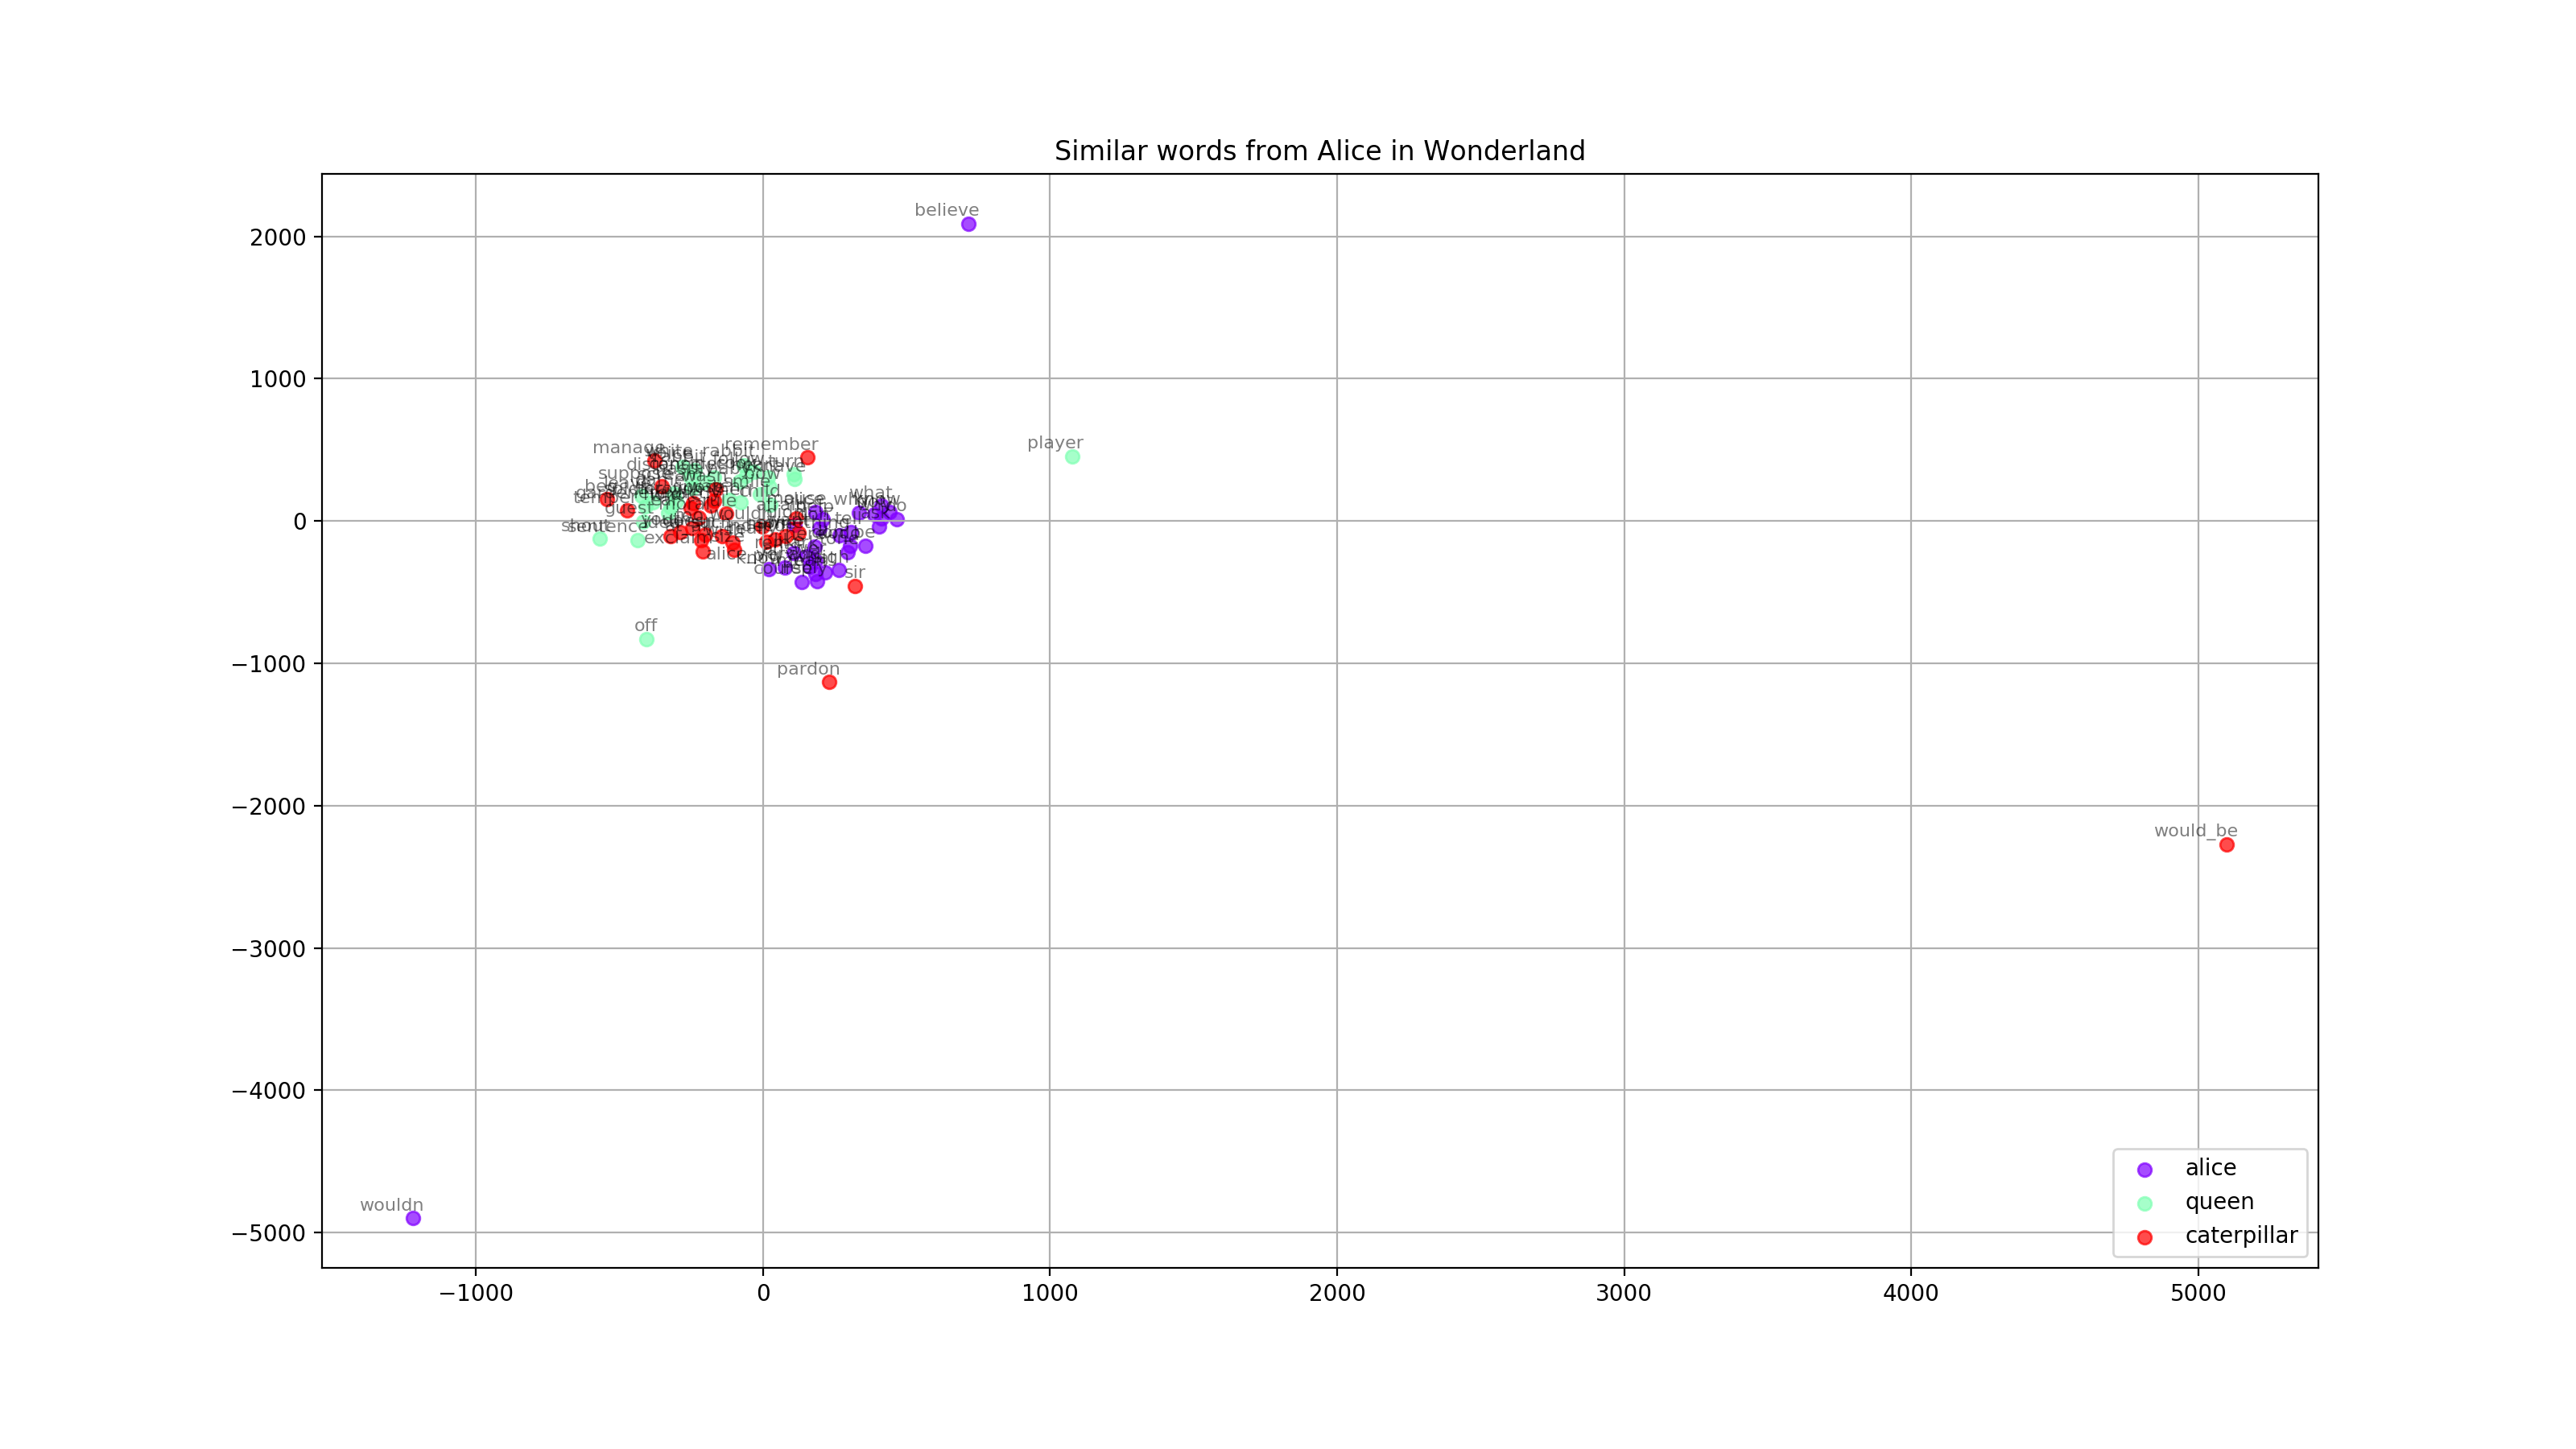

In [63]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=[color], alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar words from Alice in Wonderland', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

### Viewing the embedding in 3D

In [57]:
words_sw = []
embeddings_sw = []
for word in list(w2v_model.wv.vocab):
    embeddings_sw.append(w2v_model.wv[word])
    words_sw.append(word)

In [59]:
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(embeddings_sw)

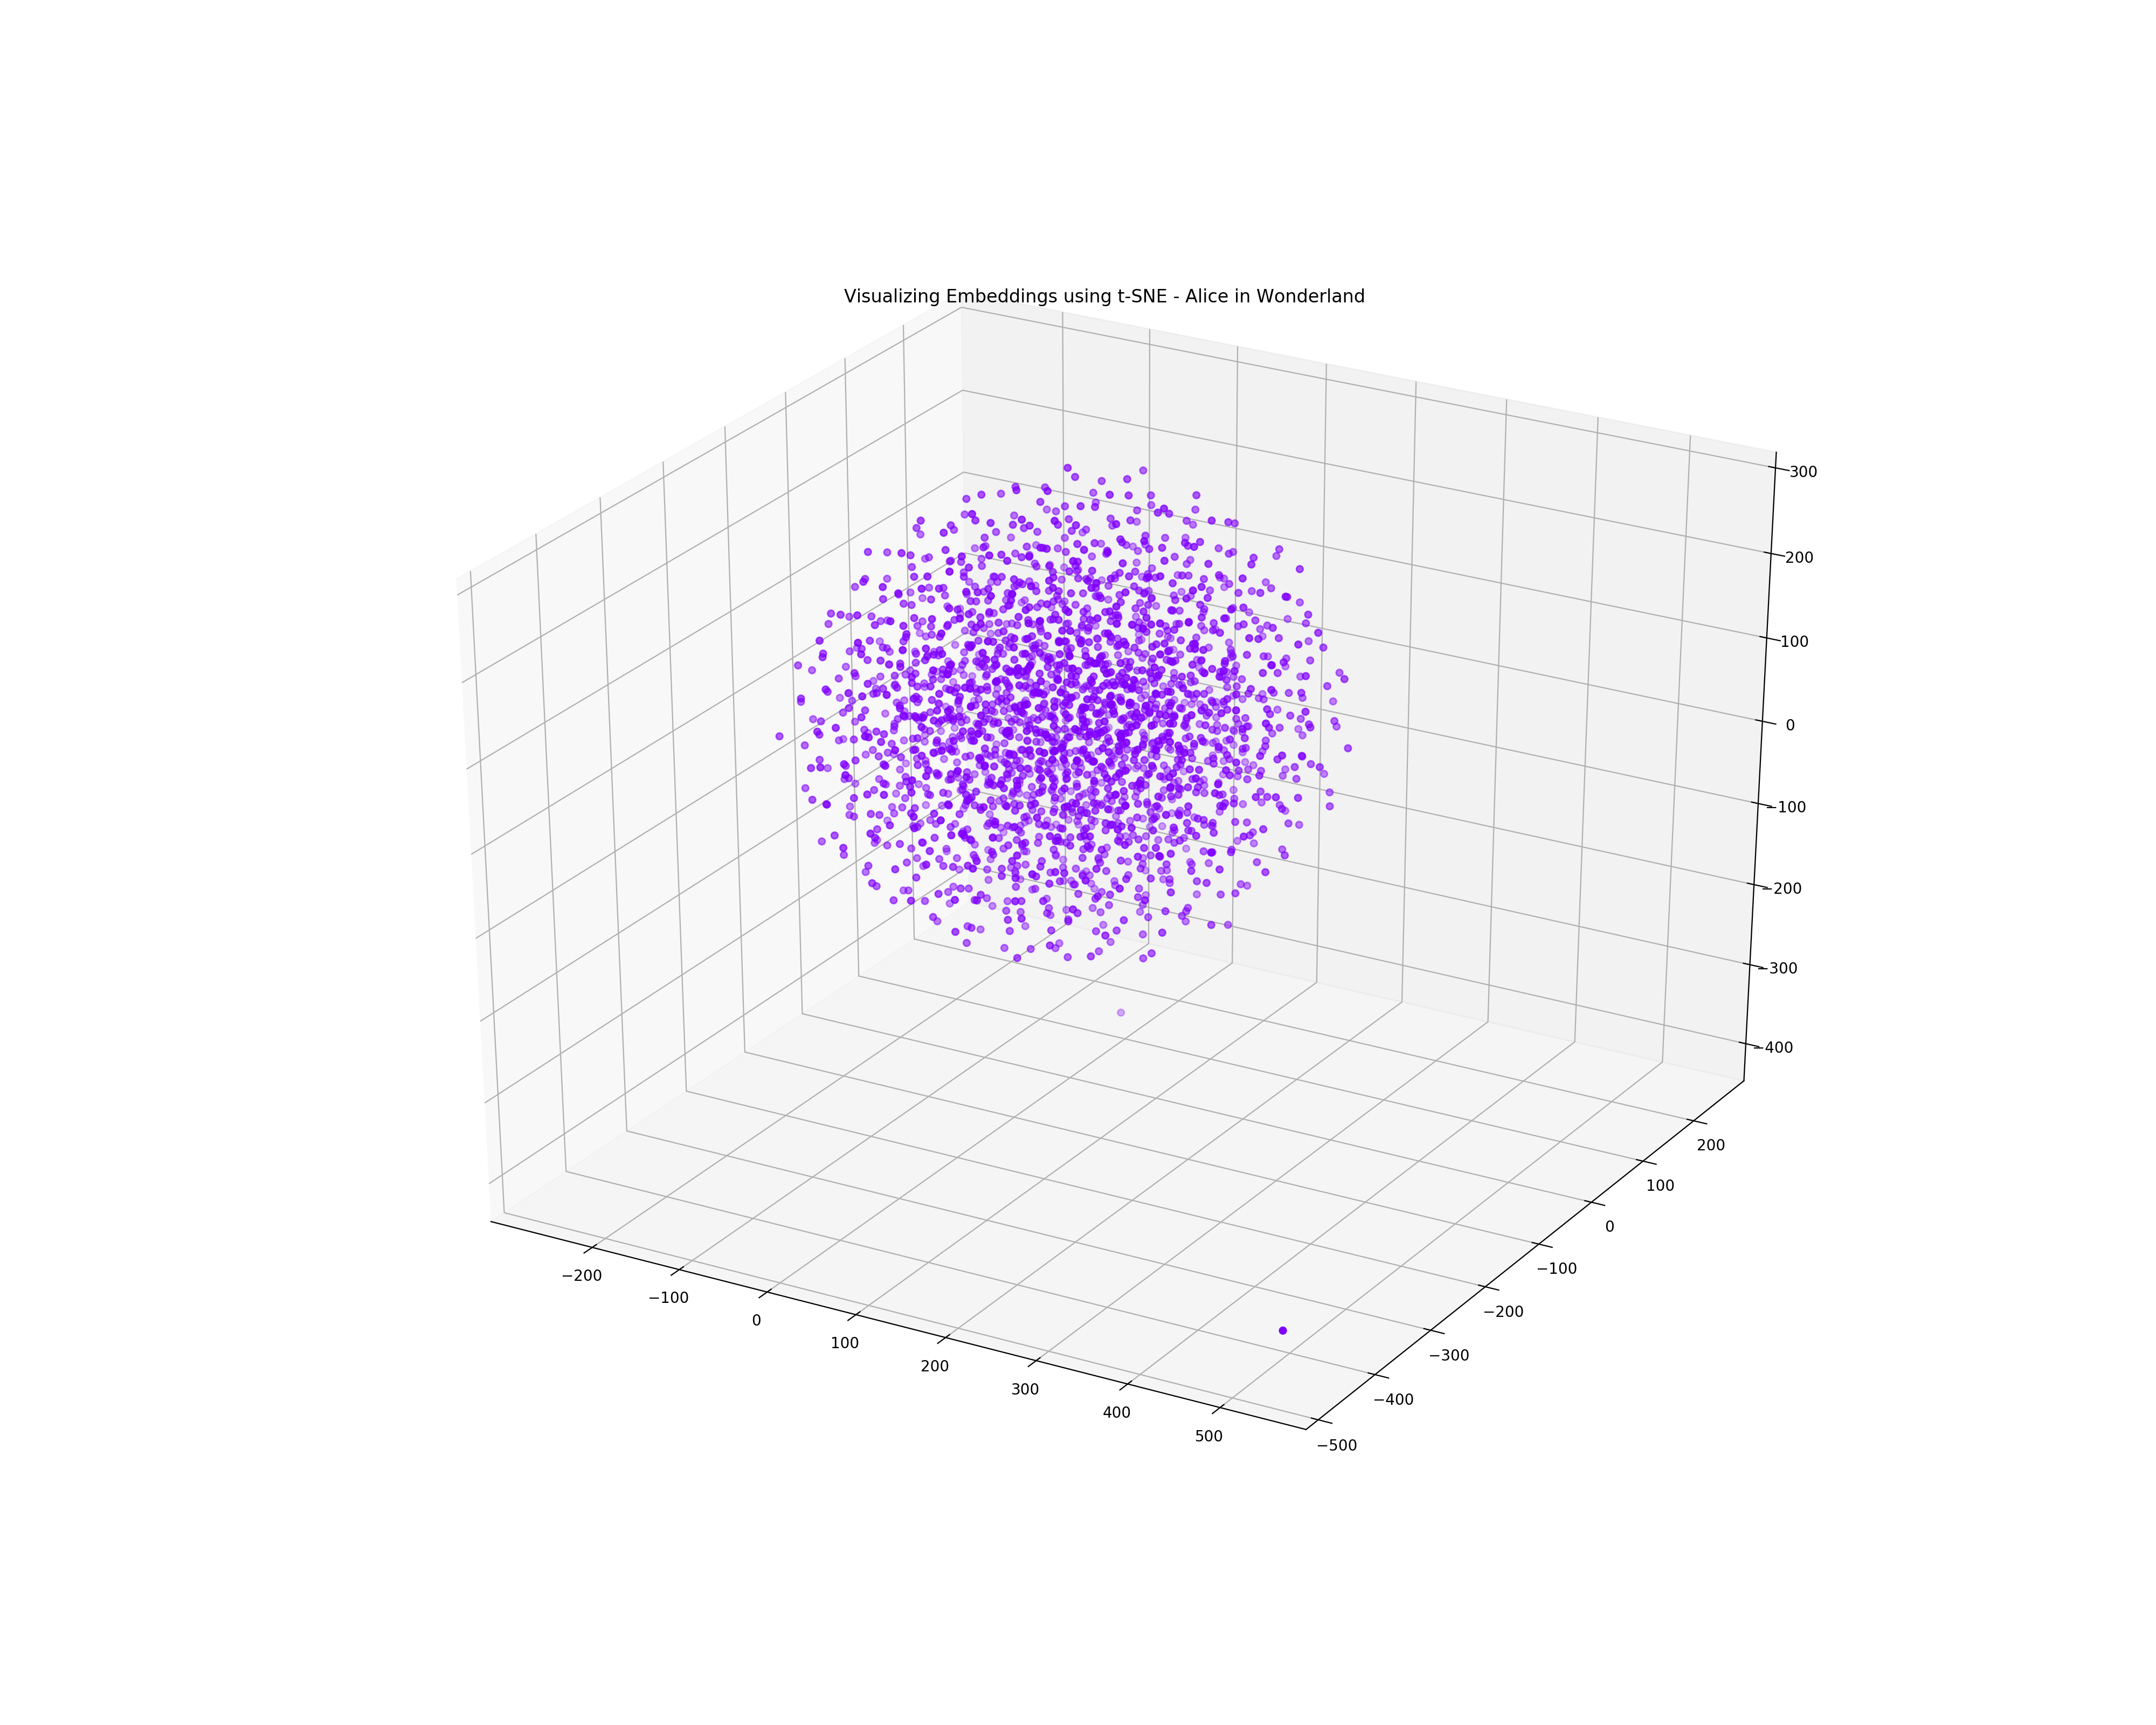

In [60]:
from mpl_toolkits.mplot3d import Axes3D
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
matplotlib.rcParams['figure.figsize'] = (20, 16)
matplotlib.rcParams['figure.dpi'] = 200

def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    plt.scatter(xs=embeddings[:, 0], 
                ys=embeddings[:, 1], 
                zs=embeddings[:, 2], 
                c=colors, 
                alpha=a, 
                label=label)
    plt.legend(loc=4)
    plt.title(title)
    plt.show()

def tsne_plot_3d2(title, embeddings, a=1): 
    ax = plt.axes(projection='3d')
    colors = cm.rainbow(np.linspace(0, 1, 1))
    ax.scatter3D(embeddings[:, 0], 
                 embeddings[:, 1], 
                 embeddings[:, 2], 
                 c=colors)
    plt.title(title)
    plt.show()

tsne_plot_3d2('Visualizing Embeddings using t-SNE - Alice in Wonderland', embeddings_wp_3d, a=0.1)

### Applications 

These include:

* Sentiment Analysis
* Speech Recognition
* Information Retrieval
* Question Answering

### Out of vacab words and pre-trained models

But what happes if you try and compare similarity between two words when the word2vec model hasnt seen that word before? How can we overcome this?

Pretrained models are available , eg., Googles pretrained model on Google News:

https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit

These are big models (1.5GB) and took a huge ammount of effort to train - so there is an advantage that ypoiu can dopwnload and just start using. You can immediately inject knowledge from a larger corpus than you might have access to: word2vec has a vocabulary of 3 million words and phrases trained on the google news dataset comprising ~100 billion tokens, and there's no cost to you in training time. Compare that to the relatively small book we have used here! However if you have a specilaised corpus (e.g., legal, medical) then it may not capture required knowledge to get meaningful results and you are more likley to get out of vocab results.